In [12]:
import pandas as pd
import numpy as np

In [13]:
df = pd.read_pickle('taxonomy_working.pkl')

In [14]:
df.head()

,Responsable,T1,T2,item_name,item_description,item_code,frn_id,category,_merge,item_text,tokens,n_tokens,prep_text,verbs,adjectives
0,Ana,Pollo,Alitas,Alitas 10 piezas,Salsa a elegir.,72365267,266868,Snacks,both,Snacks Alitas 10 piezas Salsa a elegir,"[snacks, alitas, piezas, salsa, elegir]",5,snacks alitas piezas salsa elegir,[elegir],[alitas]
1,Rodo,Saludable,Ensalada,Ensalada Philadelphia,"A elegir 1 Cama de lechugas Frescas, Más 3 Sem...",69394214,252803,Ensaladas,both,Ensaladas Ensalada Philadelphia A elegir 1 Cam...,"[ensaladas, ensalada, philadelphia, elegir, ca...",20,ensaladas ensalada philadelphia elegir cama le...,"[elegir, elegir]","[ensalada, philadelphia, frescas, fresas]"
2,Jose,Tacos,Tacos Otros,Hamburguesa Valdéz,"200 grs. De molida de sirloin, pan artesanal, ...",65,207665,Hamburguesas al Carbón,both,Hamburguesas al Carbón Hamburguesa Valdéz 200 ...,"[hamburguesas, carbón, hamburguesa, valdéz, gr...",22,hamburguesas carbón hamburguesa valdéz grs mol...,[],"[artesanal, asadero, amarillo, acompañada]"
3,Alfredo,Hamburguesas,Hamburguesa,LA BBQ DE LUXE!,"pan artesanal,jitomate, cebolla lechuga, pepin...",33141492,48028,HAMBURGUESAS AL CARBON,both,HAMBURGUESAS AL CARBON LA BBQ DE LUXE pan art...,"[hamburguesas, carbon, bbq, luxe, pan, artesan...",16,hamburguesas carbon bbq luxe pan artesanal jit...,[],"[artesanal, fritos]"
4,Ana,Pizza,Pizza gourmet,2 Pizza Grande 4 Ingredientes.,"Base de salsa pomodora, queso mozzarella y que...",539849,539157,Pizzas,both,Pizzas 2 Pizza Grande 4 Ingredientes Base de ...,"[pizzas, pizza, grande, ingredientes, base, sa...",11,pizzas pizza grande ingredientes base salsa po...,[],[grande]


# embedding

In [15]:
import string
import gensim

sentences = df.tokens


In [16]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

fname = "w2v_final.kv"


In [17]:
word_model = gensim.models.Word2Vec.load(fname, mmap='r')
pretrained_weights = word_model.wv.vectors


def word2idx(word):
    return word_model.wv.vocab[word].index
def idx2word(idx):
    return word_model.wv.index2word[idx]


In [18]:
# save for tensorboard embedding projector viz
# word_model.wv.save_word2vec_format('dish_w2v')
# shell run: python -m gensim.scripts.word2vec2tensor --input dish_w2v --output dish_w2v

## BiLSTM

In [19]:
# This code is inspirated by https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [20]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout, GRU,Flatten


def ffn(maxlen, max_features, embed_size, embedding_matrix, n_classes):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)

    return model


def BidLstmAtt(maxlen, max_features, embed_size, embedding_matrix, n_classes):
    inp = Input(shape=(maxlen, ))
    emb = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    
    x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.1,
                           recurrent_dropout=0.1))(emb)

    x = AttentionWithContext()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)

    return model

def BidLstm2(maxlen, max_features, embed_size, embedding_matrix, n_classes):
    inp = Input(shape=(maxlen, ))
    emb = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    
    convs = [Bidirectional(LSTM(250, return_sequences=True, dropout=0.1,
                           recurrent_dropout=0.1))(emb),
            Bidirectional(GRU(250, return_sequences=True, dropout=0.1,
                           recurrent_dropout=0.1))(emb)]

    x = Concatenate(axis = 1)(convs)
    x = AttentionWithContext()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inp, outputs=x)

    return model

## train test split

In [21]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Naive class imbalance correction
imbal = df.T2.value_counts().index[df.T2.value_counts() < 10]

df['T2_isimbal'] = df.T2.map(lambda x: x in list(imbal))
df['T2_corrected'] = df.T2

df.loc[df.T2_isimbal,['T2_corrected']] = 'Otros otros' 

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df.T2_corrected.map(str))
print(integer_encoded)


[ 0 23 57 ... 42 43 28]


In [22]:
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

/home/fred/Desktop/taxonomy/env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

docs = df.prep_text

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(df.prep_text)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# print(encoded_docs)

# pad documents to a max length of 4 words
max_length = 35
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs.shape)


(6681, 35)


In [26]:
n_classes = y.shape[1]

In [28]:
print('\nPreparing the data for LSTM...')
X = np.zeros([len(sentences), max_length], dtype=np.int32)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence[:max_length]):
        X[i, t] = word2idx(word)
print('X shape:', X.shape)



Preparing the data for LSTM...
X shape: (6681, 35)


In [29]:
from sklearn.model_selection import train_test_split

# X = padded_docs
# le.inverse_transform([0, 0, 1, 2])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [30]:
n_classes

64

In [37]:
vocab_size, embedding_size = pretrained_weights.shape

model = BidLstmAtt(maxlen=max_length,
                max_features= vocab_size,
                embed_size= embedding_size,
                embedding_matrix=pretrained_weights,
                n_classes=64)

In [38]:
# Load TENSORBOARD
%load_ext tensorboard
# Start TENSORBOARD
%tensorboard --logdir ./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31668), started 4:55:12 ago. (Use '!kill 31668' to kill it.)

In [39]:
from keras.utils import plot_model
# plot_model(model, to_file='bilstmatt.png')

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 35)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 35, 100)           557800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 35, 600)           962400    
_________________________________________________________________
attention_with_context_3 (At (None, 600)               361200    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               153856    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1644

In [40]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
np.random.seed(7)

model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
file_path = ".model.hdf5"
ckpt = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,
                           save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
tensorBoard = TensorBoard(log_dir = "./logs", histogram_freq = 1)


In [41]:
model.fit(X_train, y_train, batch_size=500, epochs=100, validation_split=0.1, callbacks=[tensorBoard,ckpt, early])
#model.fit(xtr, y, batch_size=256, epochs=1, validation_split=0.1)

Train on 4809 samples, validate on 535 samples
Epoch 1/100
4809/4809 [==============================] - 21s 4ms/step - loss: 3.5490 - accuracy: 0.2163 - val_loss: 2.6437 - val_accuracy: 0.4561

Epoch 00001: val_loss improved from inf to 2.64367, saving model to .model.hdf5
Epoch 2/100
4809/4809 [==============================] - 20s 4ms/step - loss: 2.1062 - accuracy: 0.5357 - val_loss: 1.7187 - val_accuracy: 0.6093

Epoch 00002: val_loss improved from 2.64367 to 1.71871, saving model to .model.hdf5
Epoch 3/100
4809/4809 [==============================] - 16s 3ms/step - loss: 1.4886 - accuracy: 0.6629 - val_loss: 1.3917 - val_accuracy: 0.6953

Epoch 00003: val_loss improved from 1.71871 to 1.39168, saving model to .model.hdf5
Epoch 4/100
4809/4809 [==============================] - 17s 4ms/step - loss: 1.1735 - accuracy: 0.7207 - val_loss: 1.2085 - val_accuracy: 0.7290

Epoch 00004: val_loss improved from 1.39168 to 1.20846, saving model to .model.hdf5
Epoch 5/100
4809/4809 [==========

In [35]:
model.save('bilstm_attention_V1.h5')

# Model evaluation

In [36]:
from keras.models import load_model

model = load_model('bilstm_attention_V1.h5', custom_objects={'Attention' : Attention})
#model = Model(inputs=model.input,
              #outputs=[model.output, model.get_layer('attention_7').output])

In [42]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 76.140612


In [43]:
from sklearn.metrics import confusion_matrix

In [44]:
y_pred = model.predict(X_test)
y_pred_decoded = np.argmax(y_pred,axis=1)

In [45]:
y_test_decoded = np.argmax(y_test,axis=1)

In [46]:
confusion_matrix(y_test_decoded, y_pred_decoded)

array([[26,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0, 13, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  8,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  1]])

In [30]:
import seaborn as sn
import matplotlib.pyplot as plt 

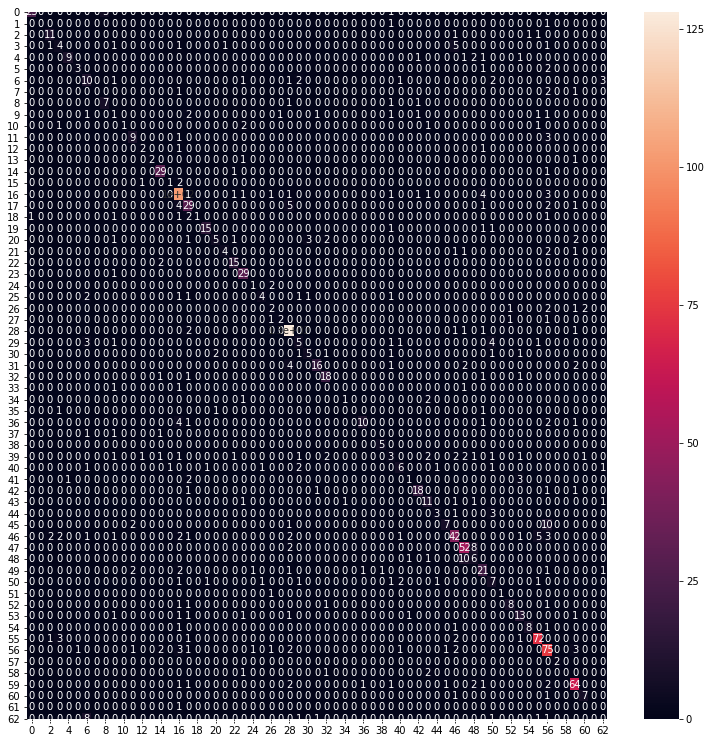

In [31]:
from sklearn import metrics
plt.figure(figsize = (13,13))
sn.heatmap(metrics.confusion_matrix(y_test_decoded, y_pred_decoded), annot=True)


In [47]:
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.metrics import *

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)

    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


In [48]:
multiclass_roc_auc_score(y_test_decoded,y_pred_decoded)

0.8134433000195598

In [49]:
y_pred_decoded[:15]

array([28, 54, 60, 23, 28, 28, 57, 60, 56, 23, 16, 54, 60, 60, 60])

In [50]:
y_test_decoded[:15]

array([28, 54, 60, 23, 28, 28, 57, 28, 56, 23, 16, 54, 60, 60, 60])

In [51]:
accuracy_score(y_test_decoded, y_pred_decoded)

0.7614061331338818

## Visualizing attention

In [300]:
outputs = model.predict(X_test)
model_outputs = outputs[0]
attention_outputs = outputs[1]

In [301]:
np.argmax(model_outputs,axis=1)

array([57, 56, 46, ...,  0, 22, 49])

In [406]:
import random
i = random.randint(0,len(df))

In [407]:
df.prep_text[i]

'huevo divorciar incluir porción fríjol pieza pan bolillo café vaso fruto'

In [419]:
outputs = model.predict(padded_docs[i:i+1])


In [420]:
pred_class = np.argmax(outputs,axis=1)
print(pred_class)

[3]


In [424]:
label_encoder.inverse_transform([3])

array(['Asiática otros'], dtype=object)

In [411]:
df.T2_corrected[i]

'Huevos y omelet'